In [25]:
import matplotlib.pyplot as plt
import numpy
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.distributions import distribution

In [2]:
# hyperparams
inp_dim = 28 * 28
#try to use other model params. check overfitting with large models
hidden = 350
out_dim = 60
device_id = 0
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 10
batch_size = 128

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5)),
     ])


dataset_train = datasets.MNIST('.', 
                               train=True,            
                               download=True, 
                               transform=transform)
trainloader = torch.utils.data.DataLoader(dataset_train, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=2, 
                                          drop_last = True,)

dataset_test = datasets.MNIST('.', 
                              train=False,
                              download=True, 
                              transform=transform)
testloader = torch.utils.data.DataLoader(dataset_train, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=2, 
                                          drop_last = True,)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:
input_channels = 1
hidden_channels = 100

In [5]:
class ConvEncoder(nn.Module):
  #28*28 -> hidden -> hidden_out
  def __init__(self, input_ch, hidden_ch, dropout_p=0.1):
    super().__init__()
    
    self.conv1 = nn.Conv2d(input_ch, hidden_ch, kernel_size=5, padding=2, stride=1) # 28x28
    self.bn1 = nn.BatchNorm2d(hidden_ch)
    self.do1 = nn.Dropout(dropout_p)
    self.pool1 = nn.MaxPool2d(2, 2) # 14x14
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, padding=1, stride=1) # 14x14
    self.bn2 = nn.BatchNorm2d(hidden_ch)
    self.do2 = nn.Dropout(dropout_p)
    self.pool2 = nn.MaxPool2d(2, 2) # 7x7
    self.conv3 = nn.Conv2d(hidden_ch, 1, kernel_size=3, padding=1, stride=1) # 7x7


    self.activ = nn.ReLU()

  def forward(self, x):
    x = self.pool1(self.do1(self.activ(self.bn1(self.conv1(x)))))
    x = self.pool2(self.do2(self.activ(self.bn2(self.conv2(x)))))
    x = self.conv3(x)

    return x


class ConvDecoder(nn.Module):
  #hidden_out-> hidden -> 28*28 
  def __init__(self, input_ch, hidden_ch, dropout_p=0.1):
    super().__init__()
    
    self.conv1 = nn.Conv2d(1, hidden_ch, kernel_size=3, padding=1, stride=1) # 7x7
    self.bn1 = nn.BatchNorm2d(hidden_ch)
    self.do1 = nn.Dropout(dropout_p)
    self.upsample1 = nn.UpsamplingNearest2d(scale_factor=2) # 14x14
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, padding=1, stride=1) # 14x14
    self.bn2 = nn.BatchNorm2d(hidden_ch)
    self.do2 = nn.Dropout(dropout_p)
    self.upsample2 = nn.UpsamplingNearest2d(scale_factor=2) # 28x28
    self.conv3 = nn.Conv2d(hidden_ch, input_ch, kernel_size=5, padding=2, stride=1) # 28x28
    
    self.activ = nn.ReLU()
  
  def forward(self, x):
    x = self.upsample1(self.do1(self.activ(self.bn1(self.conv1(x)))))
    x = self.upsample2(self.do2(self.activ(self.bn2(self.conv2(x)))))
    x = self.conv3(x)

    return x



class ConvAutoEncoder(nn.Module):
  def __init__(self, input_ch, hidden_ch, ):
    super().__init__()
    self.encoder = ConvEncoder(input_ch, hidden_ch, )
    self.decoder = ConvDecoder(input_ch, hidden_ch, )

  def forward(self, x):
    hidden = self.encoder(x)
    x_ = self.decoder(hidden)

    return x_

In [6]:
model = ConvAutoEncoder(input_channels, hidden_channels).to(device)
optim = torch.optim.Adam(model.parameters())
loss_func = nn.MSELoss()

epoch: 0, step: 0, loss: 1.0571024417877197
epoch: 0, step: 200, loss: 0.0723801925778389
epoch: 0, step: 400, loss: 0.06333643198013306


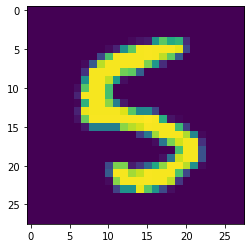

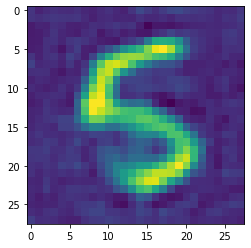

epoch: 1, step: 0, loss: 0.054158374667167664
epoch: 1, step: 200, loss: 0.05452590063214302
epoch: 1, step: 400, loss: 0.047511402517557144


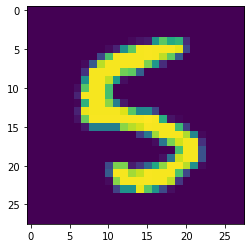

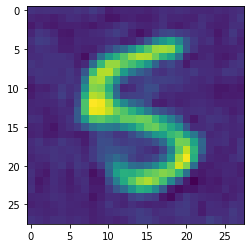

epoch: 2, step: 0, loss: 0.047149658203125
epoch: 2, step: 200, loss: 0.0436587817966938
epoch: 2, step: 400, loss: 0.03690348565578461


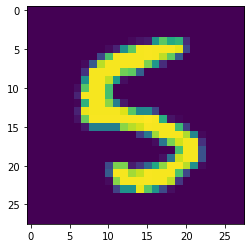

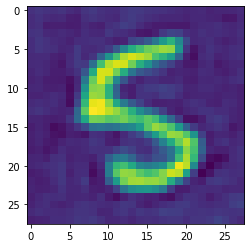

epoch: 3, step: 0, loss: 0.03944091126322746
epoch: 3, step: 200, loss: 0.04143829643726349
epoch: 3, step: 400, loss: 0.03558823838829994


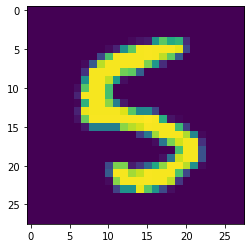

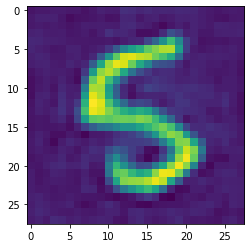

epoch: 4, step: 0, loss: 0.040025170892477036
epoch: 4, step: 200, loss: 0.03614303097128868
epoch: 4, step: 400, loss: 0.03453809395432472


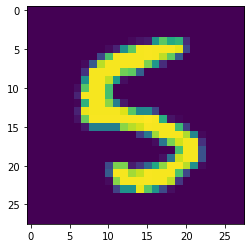

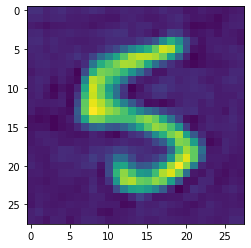

epoch: 5, step: 0, loss: 0.034953728318214417
epoch: 5, step: 200, loss: 0.03424721956253052
epoch: 5, step: 400, loss: 0.03607615455985069


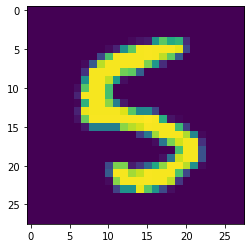

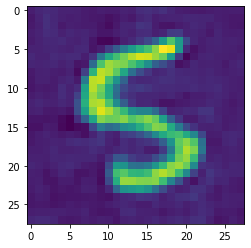

epoch: 6, step: 0, loss: 0.03511570394039154
epoch: 6, step: 200, loss: 0.03244050219655037
epoch: 6, step: 400, loss: 0.032582979649305344


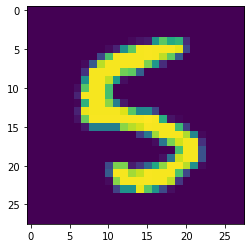

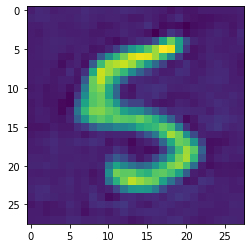

epoch: 7, step: 0, loss: 0.030689671635627747
epoch: 7, step: 200, loss: 0.0299969632178545
epoch: 7, step: 400, loss: 0.02880961447954178


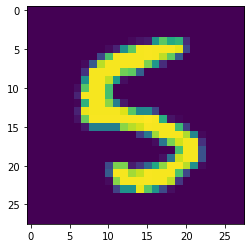

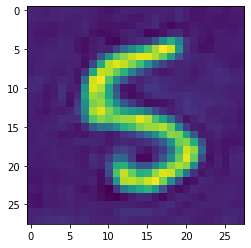

epoch: 8, step: 0, loss: 0.030015597119927406
epoch: 8, step: 200, loss: 0.029278457164764404
epoch: 8, step: 400, loss: 0.029731418937444687


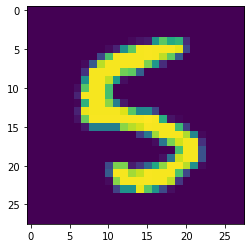

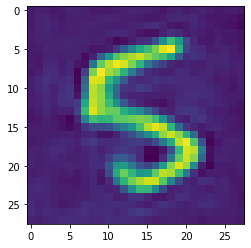

epoch: 9, step: 0, loss: 0.031831447035074234
epoch: 9, step: 200, loss: 0.029190130531787872
epoch: 9, step: 400, loss: 0.028643233701586723


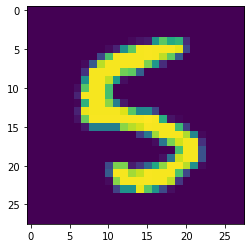

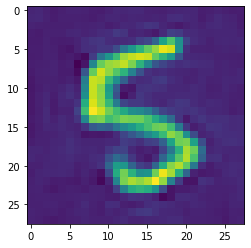

In [7]:
for epoch in range(n_epochs):
    for i, batch in enumerate(trainloader):
        inputs, labels = batch
        optim.zero_grad()

        predict = model(inputs.to(device))
        #print(predict)
        loss = loss_func(inputs.to(device), predict)
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    item = dataset_test[778][0].unsqueeze(0).to(device).float()
    plt.imshow(dataset_test[778][0].squeeze().detach().numpy())
    plt.show()
    plt.imshow(model(item).squeeze().squeeze().cpu().detach().numpy())
    plt.show()
    torch.save(model.state_dict(), f'./conv_ae_chkpt_{epoch}.pth')

In [1]:
#Попробуем применить различные способы инициализации весов

In [8]:
class ConvEncoder(nn.Module):
  #28*28 -> hidden -> hidden_out
  def __init__(self, input_ch, hidden_ch, dropout_p=0.1):
    super().__init__()
    
    self.conv1 = nn.Conv2d(input_ch, hidden_ch, kernel_size=5, padding=2, stride=1) # 28x28
    #nn.init.xavier_normal_(self.conv1.weight)
    nn.init.kaiming_normal_(self.conv1.weight)
    self.bn1 = nn.BatchNorm2d(hidden_ch)
    self.do1 = nn.Dropout(dropout_p)
    self.pool1 = nn.MaxPool2d(2, 2) # 14x14
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, padding=1, stride=1) # 14x14
    #nn.init.xavier_normal_(self.conv2.weight)
    nn.init.kaiming_normal_(self.conv2.weight)
    self.bn2 = nn.BatchNorm2d(hidden_ch)
    self.do2 = nn.Dropout(dropout_p)
    self.pool2 = nn.MaxPool2d(2, 2) # 7x7
    self.conv3 = nn.Conv2d(hidden_ch, 1, kernel_size=3, padding=1, stride=1) # 7x7


    #self.activ = nn.Sigmoid()
    self.activ = nn.ReLU()

  def forward(self, x):
    x = self.pool1(self.do1(self.activ(self.bn1(self.conv1(x)))))
    x = self.pool2(self.do2(self.activ(self.bn2(self.conv2(x)))))
    x = self.conv3(x)

    return x


class ConvDecoder(nn.Module):
  #hidden_out-> hidden -> 28*28 
  def __init__(self, input_ch, hidden_ch, dropout_p=0.1):
    super().__init__()
    
    self.conv1 = nn.Conv2d(1, hidden_ch, kernel_size=3, padding=1, stride=1) # 7x7
    #nn.init.xavier_normal_(self.conv1.weight)
    nn.init.kaiming_normal_(self.conv1.weight)
    self.bn1 = nn.BatchNorm2d(hidden_ch)
    self.do1 = nn.Dropout(dropout_p)
    self.upsample1 = nn.UpsamplingNearest2d(scale_factor=2) # 14x14
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, padding=1, stride=1) # 14x14
    #nn.init.xavier_normal_(self.conv2.weight)
    nn.init.kaiming_normal_(self.conv2.weight)
    self.bn2 = nn.BatchNorm2d(hidden_ch)
    self.do2 = nn.Dropout(dropout_p)
    self.upsample2 = nn.UpsamplingNearest2d(scale_factor=2) # 28x28
    self.conv3 = nn.Conv2d(hidden_ch, input_ch, kernel_size=5, padding=2, stride=1) # 28x28
    
    #self.activ = nn.Sigmoid()
    self.activ = nn.ReLU()
  
  def forward(self, x):
    x = self.upsample1(self.do1(self.activ(self.bn1(self.conv1(x)))))
    x = self.upsample2(self.do2(self.activ(self.bn2(self.conv2(x)))))
    x = self.conv3(x)

    return x



class ConvAutoEncoder(nn.Module):
  def __init__(self, input_ch, hidden_ch, ):
    super().__init__()
    self.encoder = ConvEncoder(input_ch, hidden_ch, )
    self.decoder = ConvDecoder(input_ch, hidden_ch, )

  def forward(self, x):
    hidden = self.encoder(x)
    x_ = self.decoder(hidden)

    return x_

In [9]:
model = ConvAutoEncoder(input_channels, hidden_channels).to(device)
optim = torch.optim.Adam(model.parameters())
loss_func = nn.MSELoss()

epoch: 0, step: 0, loss: 0.8090439438819885
epoch: 0, step: 200, loss: 0.07048226147890091
epoch: 0, step: 400, loss: 0.05864919349551201


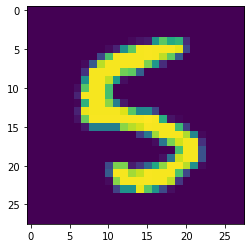

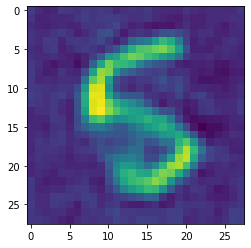

epoch: 1, step: 0, loss: 0.062141042202711105
epoch: 1, step: 200, loss: 0.056823719292879105
epoch: 1, step: 400, loss: 0.04755270108580589


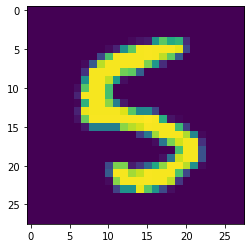

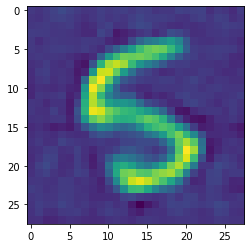

epoch: 2, step: 0, loss: 0.048889439553022385
epoch: 2, step: 200, loss: 0.04538064822554588
epoch: 2, step: 400, loss: 0.041585784405469894


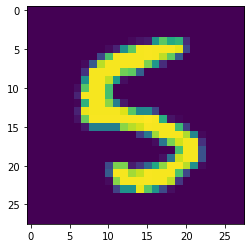

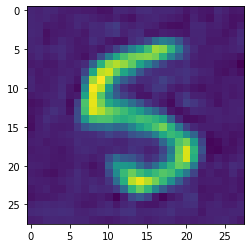

epoch: 3, step: 0, loss: 0.04412548616528511
epoch: 3, step: 200, loss: 0.04108281806111336
epoch: 3, step: 400, loss: 0.04115305095911026


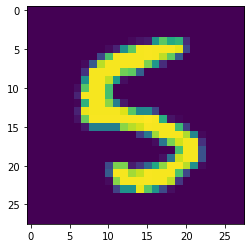

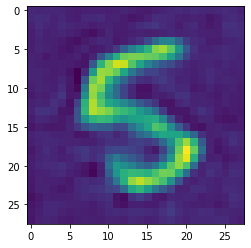

epoch: 4, step: 0, loss: 0.039719898253679276
epoch: 4, step: 200, loss: 0.038009461015462875
epoch: 4, step: 400, loss: 0.036881402134895325


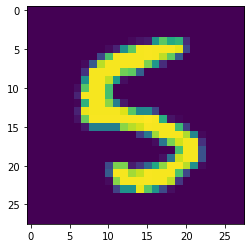

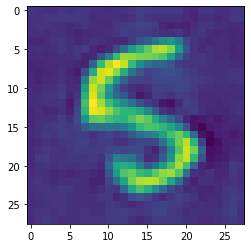

epoch: 5, step: 0, loss: 0.036590009927749634
epoch: 5, step: 200, loss: 0.03798514977097511
epoch: 5, step: 400, loss: 0.034521300345659256


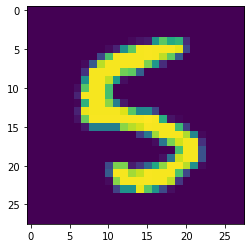

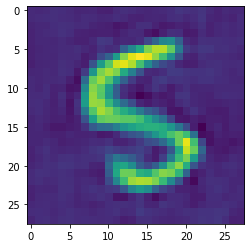

epoch: 6, step: 0, loss: 0.03455450385808945
epoch: 6, step: 200, loss: 0.03384678065776825
epoch: 6, step: 400, loss: 0.032468777149915695


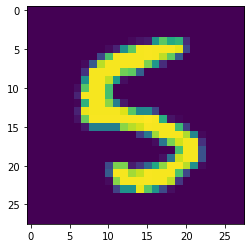

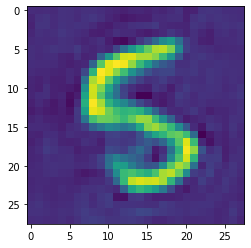

epoch: 7, step: 0, loss: 0.030358530580997467
epoch: 7, step: 200, loss: 0.03181738033890724
epoch: 7, step: 400, loss: 0.03240632638335228


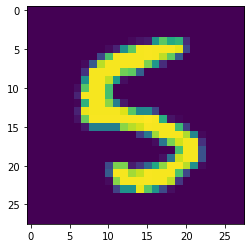

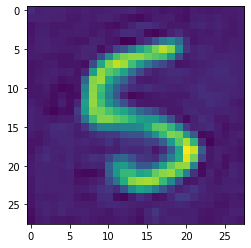

epoch: 8, step: 0, loss: 0.029721474274992943
epoch: 8, step: 200, loss: 0.03282974287867546
epoch: 8, step: 400, loss: 0.03335210308432579


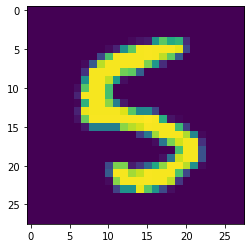

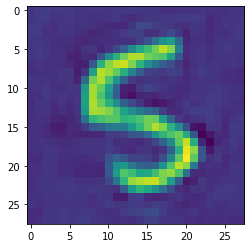

epoch: 9, step: 0, loss: 0.03376169875264168
epoch: 9, step: 200, loss: 0.029952209442853928
epoch: 9, step: 400, loss: 0.028840091079473495


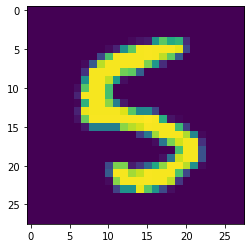

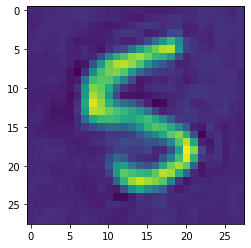

In [10]:
for epoch in range(n_epochs):
    for i, batch in enumerate(trainloader):
        inputs, labels = batch
        optim.zero_grad()

        predict = model(inputs.to(device))
        #print(predict)
        loss = loss_func(inputs.to(device), predict)
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    item = dataset_test[778][0].unsqueeze(0).to(device).float()
    plt.imshow(dataset_test[778][0].squeeze().detach().numpy())
    plt.show()
    plt.imshow(model(item).squeeze().squeeze().cpu().detach().numpy())
    plt.show()
    torch.save(model.state_dict(), f'./conv_ae_chkpt_{epoch}.pth')

In [26]:
# Результат немного ухудшился
# Теперь попробуем добавить еще один слой и используем метрику MAE

In [11]:
input_channels = 1
hidden_channels = 64

In [12]:
class ConvEncoder(nn.Module):
  #28*28 -> hidden -> hidden_out
  def __init__(self, input_ch, hidden_ch, dropout_p=0.1):
    super().__init__()
    
    self.conv1 = nn.Conv2d(input_ch, hidden_ch, kernel_size=5, padding=2, stride=1) # 28x28
    self.bn1 = nn.BatchNorm2d(hidden_ch)
    self.do1 = nn.Dropout(dropout_p)
    self.pool1 = nn.MaxPool2d(2, 2) # 14x14
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, padding=1, stride=1) # 14x14
    self.bn2 = nn.BatchNorm2d(hidden_ch)
    self.do2 = nn.Dropout(dropout_p)
    self.pool2 = nn.MaxPool2d(2, 2) # 7x7
    self.conv3 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, padding=1, stride=1) # 7x7
    self.bn3 = nn.BatchNorm2d(hidden_ch)
    self.do3 = nn.Dropout(dropout_p)
    self.conv4 = nn.Conv2d(hidden_ch, 1, kernel_size=3, padding=1, stride=1) # 7x7


    self.activ = nn.ReLU()

  def forward(self, x):
    x = self.pool1(self.do1(self.activ(self.bn1(self.conv1(x)))))
    x = self.pool2(self.do2(self.activ(self.bn2(self.conv2(x)))))
    x= self.do3(self.activ(self.bn3(self.conv3(x))))
    x = self.conv4(x)

    return x


class ConvDecoder(nn.Module):
  #hidden_out-> hidden -> 28*28 
  def __init__(self, input_ch, hidden_ch, dropout_p=0.1):
    super().__init__()
    
    self.conv1 = nn.Conv2d(1, hidden_ch, kernel_size=3, padding=1, stride=1) # 7x7
    self.bn1 = nn.BatchNorm2d(hidden_ch)
    self.do1 = nn.Dropout(dropout_p)
    self.upsample1 = nn.UpsamplingNearest2d(scale_factor=2) # 14x14
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, padding=1, stride=1) # 14x14
    self.bn2 = nn.BatchNorm2d(hidden_ch)
    self.do2 = nn.Dropout(dropout_p)
    self.upsample2 = nn.UpsamplingNearest2d(scale_factor=2) # 28x28
    self.conv3 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, padding=1, stride=1) # 7x7
    self.bn3 = nn.BatchNorm2d(hidden_ch)
    self.do3 = nn.Dropout(dropout_p)
    self.conv4 = nn.Conv2d(hidden_ch, input_ch, kernel_size=5, padding=2, stride=1) # 28x28
    
    self.activ = nn.ReLU()
  
  def forward(self, x):
    x = self.upsample1(self.do1(self.activ(self.bn1(self.conv1(x)))))
    x = self.upsample2(self.do2(self.activ(self.bn2(self.conv2(x)))))
    x = self.do3(self.activ(self.bn3(self.conv3(x))))
    x = self.conv4(x)

    return x



class ConvAutoEncoder(nn.Module):
  def __init__(self, input_ch, hidden_ch, ):
    super().__init__()
    self.encoder = ConvEncoder(input_ch, hidden_ch, )
    self.decoder = ConvDecoder(input_ch, hidden_ch, )

  def forward(self, x):
    hidden = self.encoder(x)
    x_ = self.decoder(hidden)

    return x_

In [13]:
model = ConvAutoEncoder(input_channels, hidden_channels).to(device)
optim = torch.optim.Adam(model.parameters())
#loss_func = nn.L1Loss()
loss_func = nn.MSELoss() 

epoch: 0, step: 0, loss: 0.899173378944397
epoch: 0, step: 200, loss: 0.0594421848654747
epoch: 0, step: 400, loss: 0.04870162531733513


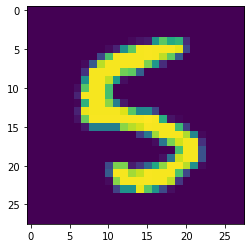

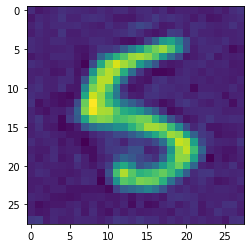

epoch: 1, step: 0, loss: 0.04152459278702736
epoch: 1, step: 200, loss: 0.03907465189695358
epoch: 1, step: 400, loss: 0.035036809742450714


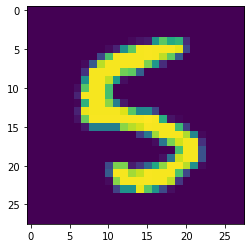

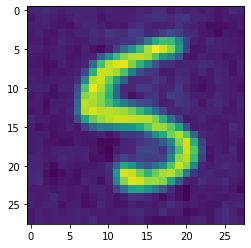

epoch: 2, step: 0, loss: 0.036138493567705154
epoch: 2, step: 200, loss: 0.03517744317650795
epoch: 2, step: 400, loss: 0.02978963777422905


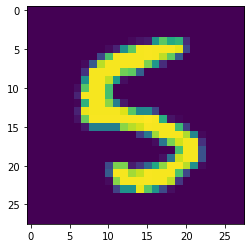

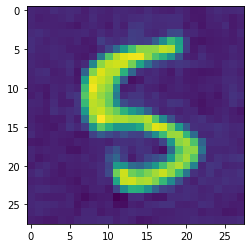

epoch: 3, step: 0, loss: 0.033994898200035095
epoch: 3, step: 200, loss: 0.028601285070180893
epoch: 3, step: 400, loss: 0.028372859582304955


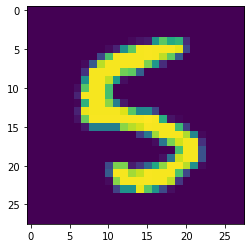

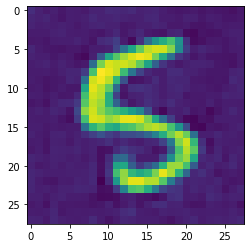

epoch: 4, step: 0, loss: 0.026645010337233543
epoch: 4, step: 200, loss: 0.028976108878850937
epoch: 4, step: 400, loss: 0.029263712465763092


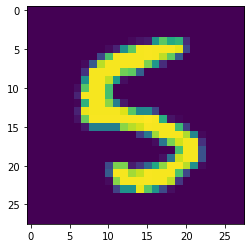

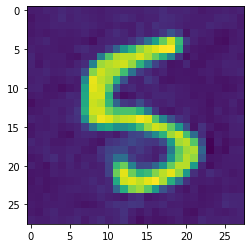

epoch: 5, step: 0, loss: 0.026058275252580643
epoch: 5, step: 200, loss: 0.02615675888955593
epoch: 5, step: 400, loss: 0.02674183063209057


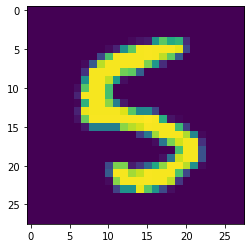

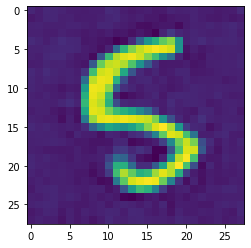

epoch: 6, step: 0, loss: 0.025140419602394104
epoch: 6, step: 200, loss: 0.024358481168746948
epoch: 6, step: 400, loss: 0.022627372294664383


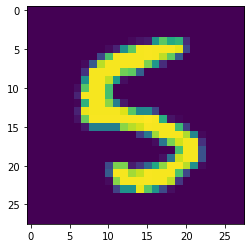

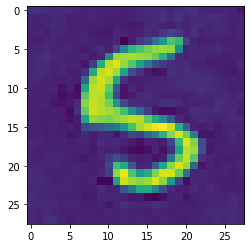

epoch: 7, step: 0, loss: 0.029035640880465508
epoch: 7, step: 200, loss: 0.023720022290945053
epoch: 7, step: 400, loss: 0.021210022270679474


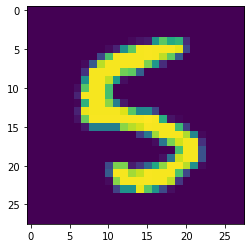

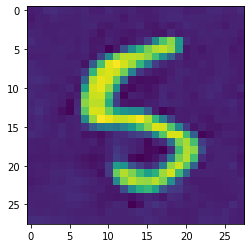

epoch: 8, step: 0, loss: 0.029583502560853958
epoch: 8, step: 200, loss: 0.022330792620778084
epoch: 8, step: 400, loss: 0.02433229237794876


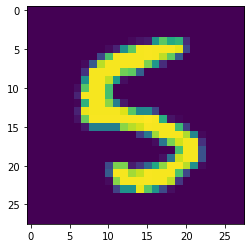

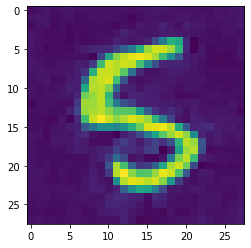

epoch: 9, step: 0, loss: 0.021722542122006416
epoch: 9, step: 200, loss: 0.02029142715036869
epoch: 9, step: 400, loss: 0.020636431872844696


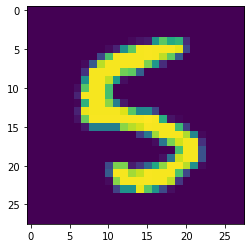

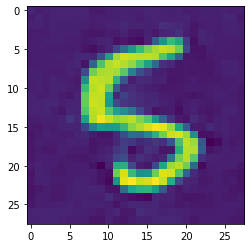

In [14]:
for epoch in range(n_epochs):
    for i, batch in enumerate(trainloader):
        inputs, labels = batch
        optim.zero_grad()

        predict = model(inputs.to(device))
        #print(predict)
        loss = loss_func(inputs.to(device), predict)
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    item = dataset_test[778][0].unsqueeze(0).to(device).float()
    plt.imshow(dataset_test[778][0].squeeze().detach().numpy())
    plt.show()
    plt.imshow(model(item).squeeze().squeeze().cpu().detach().numpy())
    plt.show()
    torch.save(model.state_dict(), f'./conv_ae_chkpt_{epoch}.pth')

In [1]:
#VAE

In [28]:
class ConvVAEncoder(nn.Module):
  #28*28 -> hidden -> hidden_out
  def __init__(self, input_ch, hidden_ch, dropout_p=0.1):
    super().__init__()
    self.conv1 = nn.Conv2d(input_ch, hidden_ch, kernel_size=5, padding=2, stride=1) # 28x28
    self.bn1 = nn.BatchNorm2d(hidden_ch)
    self.do1 = nn.Dropout(dropout_p)
    self.pool1 = nn.MaxPool2d(2, 2) # 14x14
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, padding=1, stride=1) # 14x14
    self.bn2 = nn.BatchNorm2d(hidden_ch)
    self.do2 = nn.Dropout(dropout_p)
    self.pool2 = nn.MaxPool2d(2, 2) # 7x7
    self.conv3_mu = nn.Conv2d(hidden_ch, 1, kernel_size=3, stride=1, padding=1) # 7x7
    self.conv3_sigma = nn.Conv2d(hidden_ch, 1, kernel_size=3, stride=1, padding=1) # 7x7
    self.activ = nn.ReLU()

  def forward(self, x):
    x = self.pool1(self.do1(self.activ(self.bn1(self.conv1(x)))))
    x = self.pool2(self.do2(self.activ(self.bn2(self.conv2(x)))))
    mu = self.conv3_mu(x)
    sigma = torch.exp(self.conv3_sigma(x))

    return mu, sigma

class ConvDecoder(nn.Module):

  def __init__(self, input_ch, hidden_ch, dropout_p=0.1):
    super().__init__()
    self.conv1 = nn.Conv2d(1, hidden_ch, kernel_size=3, padding=1, stride=1) # 7x7
    self.bn1 = nn.BatchNorm2d(hidden_ch)
    self.do1 = nn.Dropout(dropout_p)
    self.upsample1 = nn.UpsamplingNearest2d(scale_factor=2) # 14x14
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, padding=1, stride=1) # 14x14
    self.bn2 = nn.BatchNorm2d(hidden_ch)
    self.do2 = nn.Dropout(dropout_p)
    self.upsample2 = nn.UpsamplingNearest2d(scale_factor=2) # 28x28
    self.conv3 = nn.Conv2d(hidden_ch, input_ch, kernel_size=5, padding=2, stride=1) # 28x28
    
    self.activ = nn.ReLU()
  
  def forward(self, x):
    x = self.upsample1(self.do1(self.activ(self.bn1(self.conv1(x)))))
    x = self.upsample2(self.do2(self.activ(self.bn2(self.conv2(x)))))
    x = self.conv3(x)

    return x

def sampling(mu, sigma):
    return torch.normal(torch.zeros_like(mu), torch.ones_like(mu)) * sigma + mu

class ConvVAE(nn.Module):
  def __init__(self, input_ch, hidden_ch, ):
    super().__init__()
    self.encoder = ConvVAEncoder(input_ch, hidden_ch, )
    self.decoder = ConvDecoder(input_ch, hidden_ch, )

  def forward(self, x):
    mu, sigma = self.encoder(x)
    hidden = sampling(mu, sigma)
    x_ = self.decoder(hidden)


    return x_, mu, sigma

epoch: 0, step: 0, loss: 0.655242919921875
epoch: 0, step: 200, loss: 0.09157133102416992
epoch: 0, step: 400, loss: 0.08243896812200546


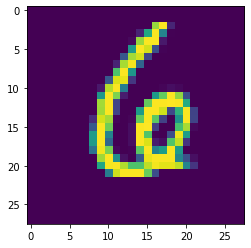

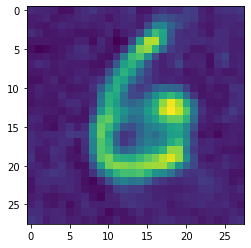

epoch: 1, step: 0, loss: 0.07769212126731873
epoch: 1, step: 200, loss: 0.07286925613880157
epoch: 1, step: 400, loss: 0.07343605160713196


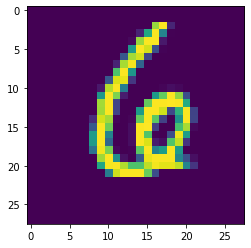

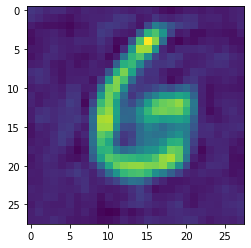

epoch: 2, step: 0, loss: 0.0672280490398407
epoch: 2, step: 200, loss: 0.0696348175406456
epoch: 2, step: 400, loss: 0.0676102489233017


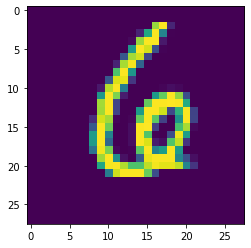

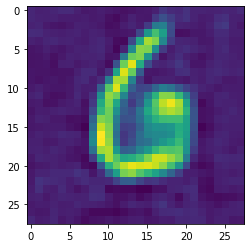

epoch: 3, step: 0, loss: 0.07164046913385391
epoch: 3, step: 200, loss: 0.06532317399978638
epoch: 3, step: 400, loss: 0.06824750453233719


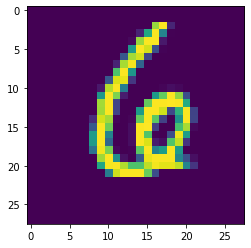

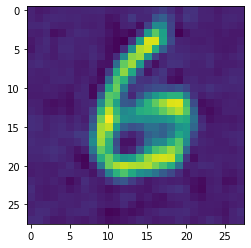

epoch: 4, step: 0, loss: 0.06591356545686722
epoch: 4, step: 200, loss: 0.05902158468961716
epoch: 4, step: 400, loss: 0.05953666940331459


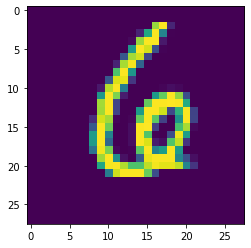

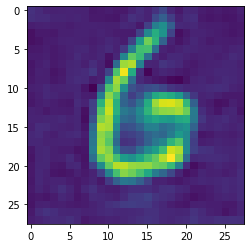

epoch: 5, step: 0, loss: 0.06219799071550369
epoch: 5, step: 200, loss: 0.06351158767938614
epoch: 5, step: 400, loss: 0.05999727547168732


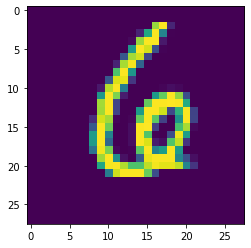

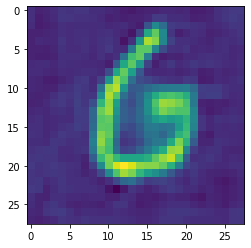

epoch: 6, step: 0, loss: 0.05936209857463837
epoch: 6, step: 200, loss: 0.05870100110769272
epoch: 6, step: 400, loss: 0.05662640929222107


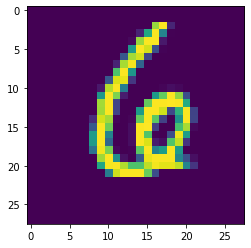

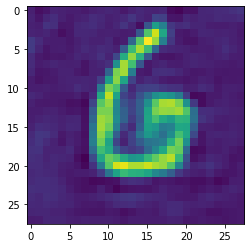

epoch: 7, step: 0, loss: 0.058881595730781555
epoch: 7, step: 200, loss: 0.056360915303230286


In [ ]:
def kl_loss(mu, sigma):
    p = torch.distributions.Normal(mu, sigma)
    q = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(mu))
    return torch.distributions.kl_divergence(p, q).mean()

model = ConvVAE(input_channels, hidden_channels).to(device)
optim = torch.optim.Adam(model.parameters())
loss_func = nn.MSELoss() #TODO try to use MAE
#loss_func = nn.L1Loss()

for epoch in range(n_epochs):
    for i, batch in enumerate(trainloader):
        inputs, labels = batch
        optim.zero_grad()
        inputs = inputs.to(device)
        
        predict, mu, sigma = model(inputs)
        loss = loss_func(inputs, predict) + 0.01 * kl_loss(mu, sigma)
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    item = dataset_test[123][0].unsqueeze(0).to(device).float()
   
    plt.imshow(item.squeeze().squeeze().cpu().detach().numpy())
    plt.show()
    plt.imshow(model(item)[0].squeeze().squeeze().cpu().detach().numpy())
    plt.show()
    torch.save(model.state_dict(), f'./lin_ae_chkpt_{epoch}.pth')